![](../header.jpg)

# Sensor Odometry

Kevin Walchko

---

**WARNING: Currently not working correctly**

$$
x^{body} = R(\phi) R(\theta) R(\psi) x^{nav} = \left[ R_x R_y R_z \right] x^{nav} = R_{321} x^{nav} \\
x^{nav} = R_{321}^T x^{body}
$$

[wikipedia: Euler angles](https://en.wikipedia.org/wiki/Euler_angles#Rotation_matrix)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import cv2          # opencv itself
import numpy as np  # matrix manipulations
np.set_printoptions(precision=4, suppress=True)

from ipywidgets import Video
from matplotlib import pyplot as plt

import wernstrom as pykitti  # this is a modified version of the original, I don't load the lidar data

from tqdm import tqdm # progress bar

from helper import imshow
from helper import videoWriter
from helper import plotSensors
from wernstrom.utils import rotz

from spiceweasel import EKF
from squaternion import Quaternion

rad2deg = 180.0/np.pi
deg2rad = np.pi/180.0

In [14]:
class MercatorProjection:
    """
    http://www.cvlibs.net/publications/Geiger2013IJRR.pdf
    https://en.wikipedia.org/wiki/Transverse_Mercator_projection
    """
    def __init__(self, lat, lon):
        self.r2d = np.pi/180
        r = 6378137 # m
        s = np.cos(lat * self.r2d)
        self.rs = r*s
        self.x0 = 0
        self.y0 = 0
        self.reset(lat,lon)
        
    def reset(self, lat, lon):
        self.x0, self.y0 = self.ll2xy(lat,lon)
        
    def ll2xy(self, lat, lon):
        x = self.rs * lon * self.r2d
        y = self.rs * np.log( np.tan( self.r2d / 2 * (lat + 90) ))
        return x-self.x0,y-self.y0
    
def kitti_pos(oxts):
    """
    Returns numpy arrays of GPS position in degrees translated
    into x, y position in meters
    """
    mp = MercatorProjection(dataset.oxts[0].packet.lat, dataset.oxts[0].packet.lon)
    x = []
    y = []
    for d in oxts:
        a = d.packet.lat
        b = d.packet.lon
        xx,yy = mp.ll2xy(a,b)
        x.append(xx)
        y.append(yy)

    x = np.array(x)
    y = np.array(y)
    return x,y

def kitti_pos2(oxts):
    # using the imu to world transform, grab the translation
    # at each step ... this should match the GPS (since it
    # was calculated using it).
    truth = np.array([x.T_w_imu[:3,3] for x in oxts])
    x = truth[:,0]
    y = truth[:,1]
    return x,y

In [3]:
dataset = pykitti.odometry("../dataset/training", "01")

Found 447 samples of data at 10Hz


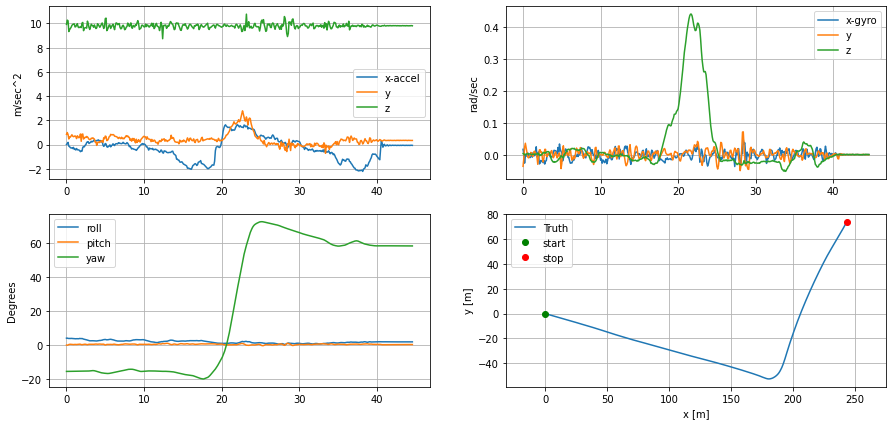

In [4]:
plotSensors(dataset.imu, dataset.oxts, dataset.timestamps, degrees=True)

In [5]:
# dataset.imu[0]

In [6]:
# def func(x, dt, u=None):
#     """
#     u = [accels, gyros]
#     """
#     if u is None:
#         u = np.zeros(6)
#     else:
#         accel = u[:3]
#         gyros = u[:]

#     p = x[:3] + x[3:6]*dt

#     rot = np.array(Quaternion(*x[6:]).to_rot())
#     g = np.array([0,0,-9.8])
#     a = np.array([0.1,0,9.8])
#     aa = rot.dot(a)
#     v = x[3:6]+g*dt+aa*dt

#     q = Quaternion(*x[6:])
#     w = Quaternion(0,u[3],u[4],u[5])
#     q = q + 0.5*w*q*dt

#     xx = np.array([0,0,0, 0,0,0, q.w,q.x,q.y,q.z])
#     xx[:3] = p
#     xx[3:6] = v

#     # print("xx", xx)

#     return xx

In [7]:
# ekf = EKF(func, 0.1)
# ekf.reset()

# u = np.array([0,0,0,  0,0,0.1])
# ekf.predict(u)
# z = np.zeros(10)
# ekf.update(z)

In [8]:
def kitti2numpy(imu):
    accel = np.array([x.accels for x in imu])
    gyro = np.array([x.gyros for x in imu])
    euler = np.array([x.euler for x in imu])
    return accel, gyro, euler

accel, gyro, euler = kitti2numpy(dataset.imu)

In [9]:
# def R321(a,b,c, degrees=False):
#     """
#     Transforms navigational (inertial) frame values to body
#     frame values. The transpose (R321.T) does body frame to 
#     navigational frame.
    
#     Args:
#         a: z
#         b: y
#         c: x
    
#     Returns a rotation matrix based on: Rx*Ry*Rz
#     """
#     if degrees:
#         a *= deg2rad
#         b *= deg2rad
#         c *= deg2rad

#     s3 = np.sin(c); c3 = np.cos(c)
#     s2 = np.sin(b); c2 = np.cos(b)
#     s1 = np.sin(a); c1 = np.cos(a)

#     return np.array(
#         [
#             [         c1*c2,          c2*s1,  -s2],
#             [c1*s2*s3-c3*s1, c1*c3+s1*s2*s3, c2*s3],
#             [s1*s3+c1*c3*s2, c3*s1*s2-c1*s3, c2*c3]
#         ]
#     )

# def R313(a,b,c, degrees=False):
#     """Returns a rotation matrix based on: Z(c)*X(b)*Z(a)"""
#     if degrees:
#         a *= deg2rad
#         b *= deg2rad
#         c *= deg2rad

#     s3 = np.sin(c); c3 = np.cos(c)
#     s2 = np.sin(b); c2 = np.cos(b)
#     s1 = np.sin(a); c1 = np.cos(a)

#     # return np.array(
#     #     [
#     #         [c1*c3-c2*s1*s3, -c1*s3-c2*c3*s1,  s1*s2],
#     #         [c3*s1+c1*c2*s3,  c1*c2*c3-s1*s3, -c1*s2],
#     #         [         s2*s3,           c3*s2,     c2]
#     #     ]
#     # )
#     return np.array(
#         [
#             [ c1*c3-c2*s1*s3, c3*s1+c1*c2*s3, s2*s3],
#             [-c1*s3-c2*c3*s1, c1*c2*c3-s1*s3, c3*s2],
#             [          s1*s2,         -c1*s2,    c2]
#         ]
#     )

# def R1(a, degrees=False):
#     if degrees:
#         a *= deg2rad
#     ca = np.cos(a)
#     sa = np.sin(a)
#     return np.array(
#         [[1,  0,   0],
#          [0,  ca, sa],
#          [0, -sa, ca]]
#     )


# def R2(a, degrees=False):
#     if degrees:
#         a *= deg2rad
#     ca = np.cos(a)
#     sa = np.sin(a)
#     return np.array(
#         [[ ca, 0, -sa],
#          [  0, 1,   0],
#          [ sa, 0,  ca]]
#     )

# def R3(a, degrees=False):
#     if degrees:
#         a *= deg2rad
#     ca = np.cos(a)
#     sa = np.sin(a)
#     return np.array(
#         [[ ca, sa, 0],
#          [-sa, ca, 0],
#          [  0,  0, 1]]
#     )

In [10]:
from scipy.integrate import solve_ivp as rk45

In [22]:
wo = np.zeros(3)
def model(t,x,u):
    global wo
    a = u[:3]
    w = u[3:6]
    e = u[6:9]
    qr = Quaternion(*u[9:])
    
    # https://physics.stackexchange.com/questions/222947/
    #    calculating-acceleration-offset-by-center-of-gravity-c-g
    c = np.array([-.27-.81,.32,.93-1.65])
    wd = (w-wo)/.1 #np.zeros(3) # i don't know angular accel
    wo = w.copy()
    a = a + np.cross(wd,c) + np.cross(w, np.cross(w, c))
    
    ans = np.zeros(10)
    
    ans[:3] = x[3:6] # pos_dot = vel
    
    q = Quaternion(*x[6:])
    # R321 = Rx Ry Rz
    # R321   nav -> body
    # R321.T body -> nav
    # R = R321(e[2], e[1], e[0]).T
    # R = np.eye(3)
    R = np.array(qr.to_rot())
    
    # R = R313(e[2], e[1], e[0]).T
    # R = R313(e[2], e[1], e[0])
    # R = R313(e[0], e[1], e[2])
    # R = R313(e[0], e[1], e[2]).T
    
    an = R @ a - np.array([0,0,9.8]) # vel_dot = accel - gravity
    # an = R1(-np.pi/2) @ ( R3(-np.pi/2) @ an )
    
    ans[3:6] = an
    
    W = Quaternion(0,*w)
    ans[6:] = 0.5*q*W
    
    return ans

In [23]:
state = np.zeros(10) #[pos, vel, q]

euler_s = np.array([
    dataset.oxts[0].packet.roll,
    dataset.oxts[0].packet.pitch,
    dataset.oxts[0].packet.yaw])

# euler_s = np.array([
#     0,
#     0,
#     0])

qs = Quaternion.from_euler(*euler_s)
print(euler_s*rad2deg)
print(qs)
state[6:] = np.array(qs)
save = []
step = 0.1
t = 0
qs = np.array(qs)

for a,g,e in zip(accel, gyro, euler):
    u = np.hstack((a,g,e,qs))
    y = rk45(model, [t,t+step], state, args=(u,))
    state = y.y[:,-1]
    save.append(state)
    qs = state[6:]
    t += step
    
save = np.array(save)

[  4.1392   0.0897 -15.4542]
Quaternion(w=0.990269240638083, x=0.03589042672891735, y=-0.004080203605387555, z=-0.13439516454779657)


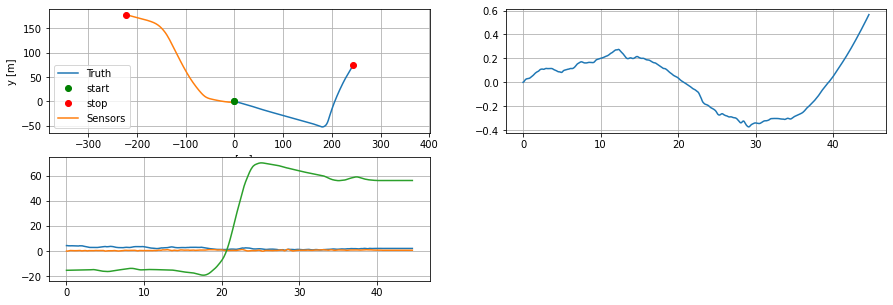

In [31]:
tx, ty = kitti_pos(dataset.oxts)

plt.figure(figsize=(15,5))

plt.subplot(221)
plt.plot(tx,ty, label='Truth')
plt.plot(tx[0],ty[0],"go", label="start")
plt.plot(tx[-1],ty[-1],"ro", label="stop")

plt.plot(save[:,0], save[:,1], label="Sensors")
plt.plot(save[0,0],save[0,1],"go")
plt.plot(save[-1,0],save[-1,1],"ro")

# plt.plot(pos[:,0],pos[:,1],"b.")

plt.grid(True)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axis('equal')
plt.legend()

plt.subplot(222)
plt.plot(dataset.timestamps, save[:,2])
plt.grid(True);

plt.subplot(223)
ee = [Quaternion(*x[6:]).to_euler(degrees=True) for x in save]
plt.plot(dataset.timestamps,ee)
plt.grid(True);

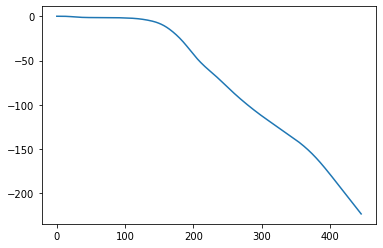

In [26]:
plt.plot(save[:,0])

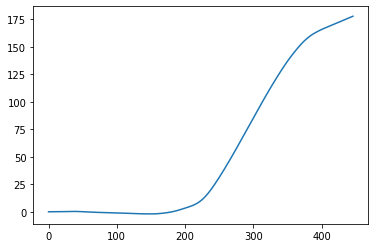

In [27]:
plt.plot(save[:,1])

In [337]:
accel2 = [np.array([x.packet.af, x.packet.al, x.packet.au]) for x in dataset.oxts]
gyro2 = [np.array([x.packet.wf, x.packet.wl, x.packet.wu]) for x in dataset.oxts]

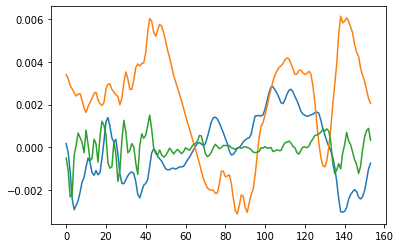

In [338]:
plt.plot(gyro - gyro2)

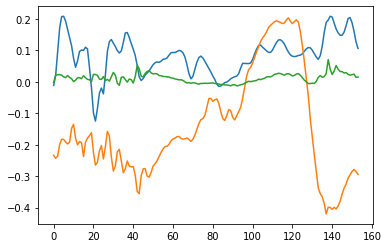

In [339]:
plt.plot(accel2-accel)

In [340]:
.2/9.8

0.02040816326530612

In [171]:
dataset.oxts[0]

OxtsData(packet=OxtsPacket(lat=49.011212804408, lon=8.4228850417969, alt=112.83492279053, roll=0.022447, pitch=1e-05, yaw=-1.2219096732051, vn=-3.3256321640686, ve=1.1384311814592, vf=3.5147680214713, vl=0.037625160413037, vu=-0.03878884255623, ax=-0.29437452763793, ay=0.037166856911681, az=9.9957015129717, af=-0.30581030960531, al=-0.19635662515203, au=9.9942128010936, wx=-0.017332142869546, wy=0.024792163815438, wz=0.14511808479348, wf=-0.017498934149631, wl=0.021393359392165, wu=0.14563031426063, pos_accuracy=0.49229361157748, vel_accuracy=0.068883960397178, navstat=4, numsats=10, posmode=4, velmode=4, orimode=0), T_w_imu=array([[ 3.41851748e-01,  9.39517225e-01, -2.10894666e-02,
         0.00000000e+00],
       [-9.39753895e-01,  3.41765417e-01, -7.68229696e-03,
         0.00000000e+00],
       [-1.00000000e-05,  2.24451150e-02,  9.99748077e-01,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]]))

In [174]:
print(dataset.oxts[0].T_w_imu)

[[ 3.41851748e-01  9.39517225e-01 -2.10894666e-02  0.00000000e+00]
 [-9.39753895e-01  3.41765417e-01 -7.68229696e-03  0.00000000e+00]
 [-1.00000000e-05  2.24451150e-02  9.99748077e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [176]:
pos = np.array([x.T_w_imu[:3,3] for x in dataset.oxts])

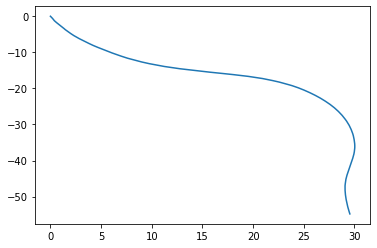

In [177]:
plt.plot(pos[:,0],pos[:,1])

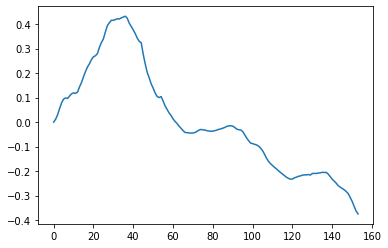

In [178]:
plt.plot(pos[:,2])

In [348]:
# calculate camera positions relative to camera0
P_rect_00 = dataset.calib.P_rect_00
P_rect_10 = dataset.calib.P_rect_10
P_rect_20 = dataset.calib.P_rect_20
P_rect_30 = dataset.calib.P_rect_30

T00 = np.eye(4)
T00[0, 3] = P_rect_00[0, 3] / P_rect_00[0, 0]
T10 = np.eye(4)
T10[0, 3] = P_rect_10[0, 3] / P_rect_10[0, 0]
T20 = np.eye(4)
T20[0, 3] = P_rect_20[0, 3] / P_rect_20[0, 0]
T30 = np.eye(4)
T30[0, 3] = P_rect_30[0, 3] / P_rect_30[0, 0]

print(T00)
print(T10)
print(T20)
print(T30)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[ 1.          0.          0.         -0.53715059]
 [ 0.          1.          0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]
[[1.       0.       0.       0.062169]
 [0.       1.       0.       0.      ]
 [0.       0.       1.       0.      ]
 [0.       0.       0.       1.      ]]
[[ 1.          0.          0.         -0.47055642]
 [ 0.          1.          0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]


In [344]:
dataset.calib._fields

('P_rect_00',
 'P_rect_10',
 'P_rect_20',
 'P_rect_30',
 'K_cam0',
 'K_cam1',
 'K_cam2',
 'K_cam3')

In [347]:
P_rect_00

array([[721.5377,   0.    , 609.5593,   0.    ],
       [  0.    , 721.5377, 172.854 ,   0.    ],
       [  0.    ,   0.    ,   1.    ,   0.    ]])

In [346]:
P_rect_00[0, 3]

0.0

In [181]:
x = np.array([1,2,3])
r = R1(np.pi/4)
print(r @ x)
print(x @ r)

[1.     3.5355 0.7071]
[ 1.     -0.7071  3.5355]


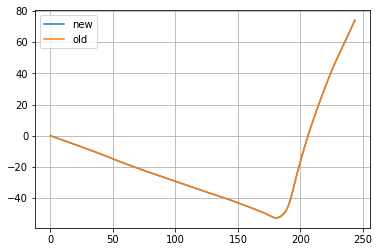

In [49]:
def go():
    # using the imu to world transform, grab the translation
    # at each step ... this should match the GPS (since it
    # was calculated using it).
    truth = np.array([x.T_w_imu[:3,3] for x in dataset.oxts])
    x = truth[:,0]
    y = truth[:,1]
    return x,y


tx, ty = kitti_pos(dataset.oxts)

plt.plot(tx,ty,label="new")
plt.plot(*go(),label="old")
plt.legend()
plt.grid(True)

In [50]:
help(dataset)

Help on odometry in module pykitti2.odometry object:

class odometry(builtins.object)
 |  odometry(base_path, sequence, **kwargs)
 |  
 |  Load and parse odometry benchmark data into a usable format.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, base_path, sequence, **kwargs)
 |      Set the path.
 |  
 |  __len__(self)
 |      Return the number of frames loaded.
 |  
 |  get_cam0(self, idx)
 |      Read image file for cam0 (monochrome left) at the specified index.
 |  
 |  get_cam1(self, idx)
 |      Read image file for cam1 (monochrome right) at the specified index.
 |  
 |  get_cam2(self, idx)
 |      Read image file for cam2 (RGB left) at the specified index.
 |  
 |  get_cam3(self, idx)
 |      Read image file for cam3 (RGB right) at the specified index.
 |  
 |  get_gray(self, idx)
 |      Read monochrome stereo pair at the specified index.
 |  
 |  get_rgb(self, idx)
 |      Read RGB stereo pair at the specified index.
 |  
 |  ------------------------------------------

In [51]:
dir(dataset)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_get_file_lists',
 '_load_calib',
 '_load_oxts',
 'base_path',
 'calib',
 'cam0',
 'cam0_files',
 'cam1',
 'cam1_files',
 'cam2',
 'cam2_files',
 'cam3',
 'cam3_files',
 'frames',
 'get_cam0',
 'get_cam1',
 'get_cam2',
 'get_cam3',
 'get_gray',
 'get_rgb',
 'gray',
 'imfmt',
 'imtype',
 'imu',
 'oxts',
 'pose_path',
 'position',
 'rgb',
 'sequence',
 'sequence_path',
 'timestamps']

In [55]:
dataset.calib

CalibData(P_rect_00=array([[721.5377,   0.    , 609.5593,   0.    ],
       [  0.    , 721.5377, 172.854 ,   0.    ],
       [  0.    ,   0.    ,   1.    ,   0.    ]]), P_rect_10=array([[ 721.5377,    0.    ,  609.5593, -387.5744],
       [   0.    ,  721.5377,  172.854 ,    0.    ],
       [   0.    ,    0.    ,    1.    ,    0.    ]]), P_rect_20=array([[721.5377,   0.    , 609.5593,  44.8573],
       [  0.    , 721.5377, 172.854 ,   0.2164],
       [  0.    ,   0.    ,   1.    ,   0.0027]]), P_rect_30=array([[ 721.5377,    0.    ,  609.5593, -339.5242],
       [   0.    ,  721.5377,  172.854 ,    2.1999],
       [   0.    ,    0.    ,    1.    ,    0.0027]]), K_cam0=array([[721.5377,   0.    , 609.5593],
       [  0.    , 721.5377, 172.854 ],
       [  0.    ,   0.    ,   1.    ]]), K_cam1=array([[721.5377,   0.    , 609.5593],
       [  0.    , 721.5377, 172.854 ],
       [  0.    ,   0.    ,   1.    ]]), K_cam2=array([[721.5377,   0.    , 609.5593],
       [  0.    , 721.5377, 172.